<a href="https://colab.research.google.com/github/Domco02/UIaN/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow tensorflow-datasets matplotlib


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def downscale(img, scale=2):
    h, w = tf.shape(img)[0], tf.shape(img)[1]
    new_h, new_w = h // scale, w // scale
    return tf.image.resize(img, (new_h, new_w), method='area')

In [ ]:
def compute_psnr(hr, sr):
    return tf.image.psnr(hr, sr, max_val=1.0)

In [ ]:
def show_pair(lr_bic, sr, hr):
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(np.clip(lr_bic,0,1)); axes[0].set_title('LR (bicubic up)')
    axes[1].imshow(np.clip(sr,0,1)); axes[1].set_title('SR')
    axes[2].imshow(np.clip(hr,0,1)); axes[2].set_title('HR')
    for ax in axes: ax.axis('off')
    plt.show()

In [ ]:
def pixel_shuffle(scale):
    return layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale))

def build_simple_espcn(scale=2, channels=3):
    x_in = layers.Input(shape=(None, None, channels))
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x_in)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D((scale**2)*channels, 3, padding='same')(x)
    x = pixel_shuffle(scale)(x)
    x = layers.Activation('sigmoid')(x)
    return models.Model(x_in, x)

model = build_simple_espcn(scale=2)
model.compile(optimizer=optimizers.Adam(1e-3), loss='mae')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 16) │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None, 12) │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, None, None, 3)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,260 (28.36 KB)

 Trainable params: 7,260 (28.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
SCALE = 2
BATCH_SIZE = 4
EPOCHS = 30  # krátky tréning pre rýchly test

CROP_SIZE = 128  # výška a šírka cropu pre tréning

def prepare_example(ex):
    hr = tf.image.convert_image_dtype(ex['hr'], tf.float32)

    # crop na pevný rozmer
    hr = tf.image.random_crop(hr, size=[CROP_SIZE*SCALE, CROP_SIZE*SCALE, 3])

    # zníženie rozlíšenia
    lr_small = downscale(hr, SCALE)

    return lr_small, hr

ds_raw = tfds.load('div2k', split='train', as_supervised=False)

# The prepare_example function from cell 5cGz5t8il30R will be used.
ds = ds_raw.map(prepare_example)
ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.TE7PPH_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.TE7PPH_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x2/2.0.0. Subsequent calls will reuse this data.


In [ ]:
history = model.fit(ds, epochs=EPOCHS)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 89s 364ms/step - loss: 0.1721
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 121s 327ms/step - loss: 0.0540
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 315ms/step - loss: 0.0460
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 64s 316ms/step - loss: 0.0418
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 310ms/step - loss: 0.0399
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 64s 311ms/step - loss: 0.0402
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 301ms/step - loss: 0.0368
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 307ms/step - loss: 0.0381
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 299ms/step - loss: 0.0364
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 63s 301ms/step - loss: 0.0348
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 63s 301ms/step - loss: 0.0339
Epoch 12/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 309ms/step - loss: 0.0333
Epoch 13/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 63s 303ms/step - loss: 0.0333
Epoch 14/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 302ms/step - loss: 0.0331
Epoch 15/30
20

In [ ]:
CROP_SIZE = 128  # výška a šírka cropu pre tréning

In [ ]:
def prepare_example(ex):
    hr = tf.image.convert_image_dtype(ex['hr'], tf.float32)

    # crop na pevný rozmer
    hr = tf.image.random_crop(hr, size=[CROP_SIZE*SCALE, CROP_SIZE*SCALE, 3])

    # zníženie rozlíšenia
    lr_small = downscale(hr, SCALE)

    return lr_small, hr

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


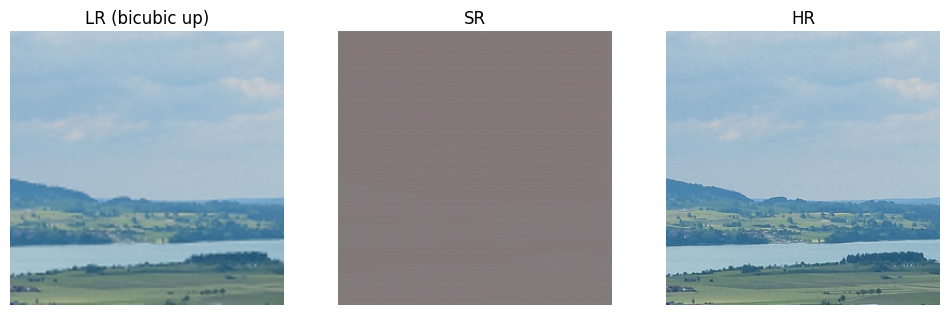

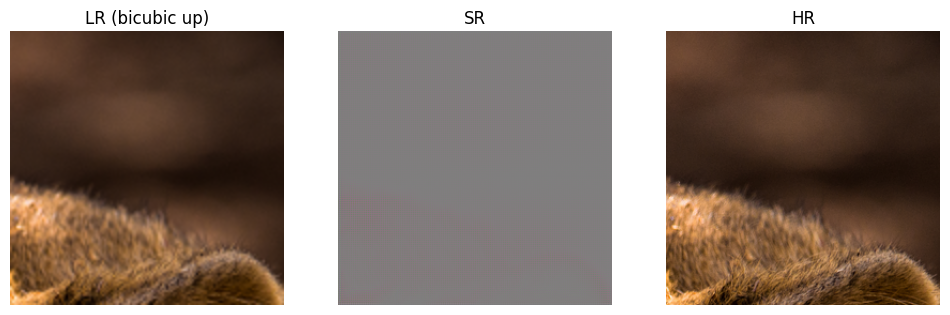

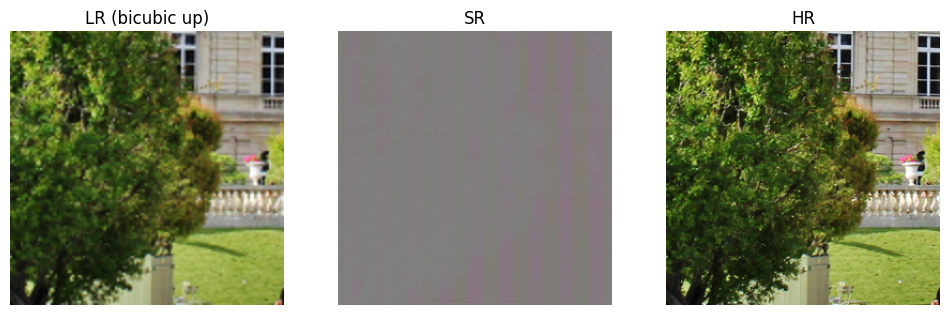

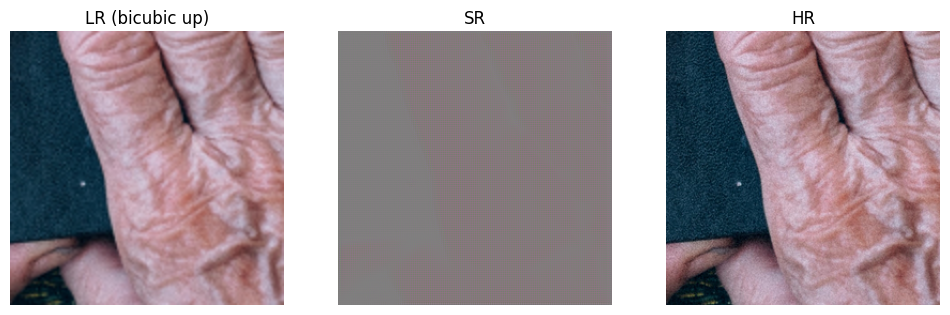

In [ ]:
for lr_small, hr in ds.take(1):
    sr = model.predict(lr_small)
    for i in range(len(sr)):
        lr_bic = tf.image.resize(lr_small[i], tf.shape(hr[i])[:2], method='bicubic')
        show_pair(lr_bic.numpy(), sr[i], hr[i].numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


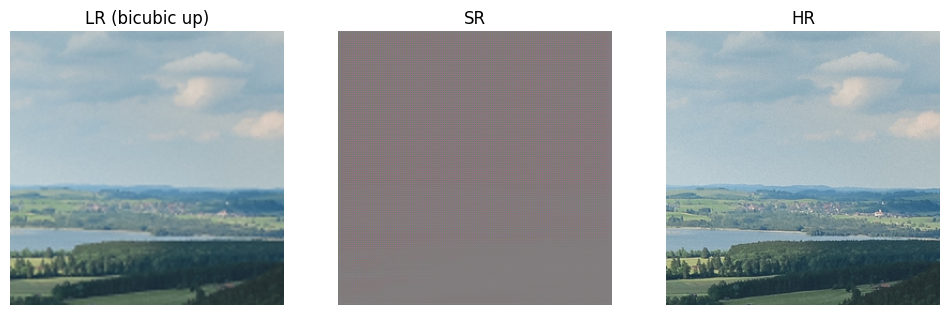

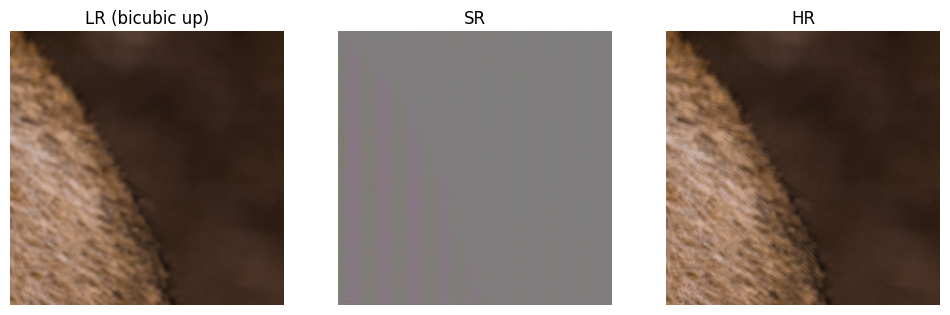

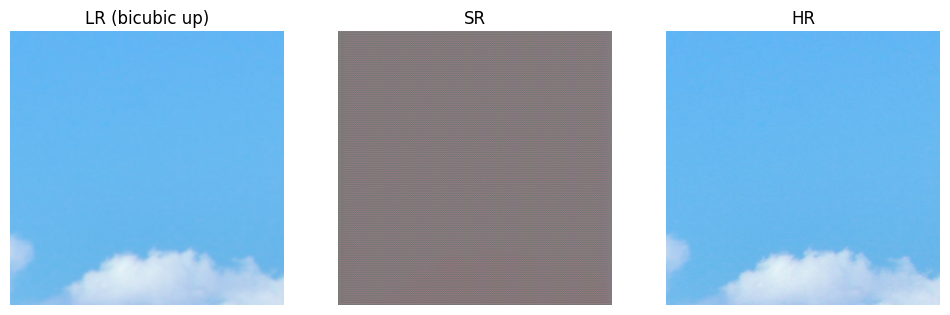

In [ ]:
for lr_small, hr in ds.take(1):
    sr = model.predict(lr_small)
    for i in range(len(sr)):
        lr_bic = tf.image.resize(lr_small[i], tf.shape(hr[i])[:2], method='bicubic')
        show_pair(lr_bic.numpy(), sr[i], hr[i].numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


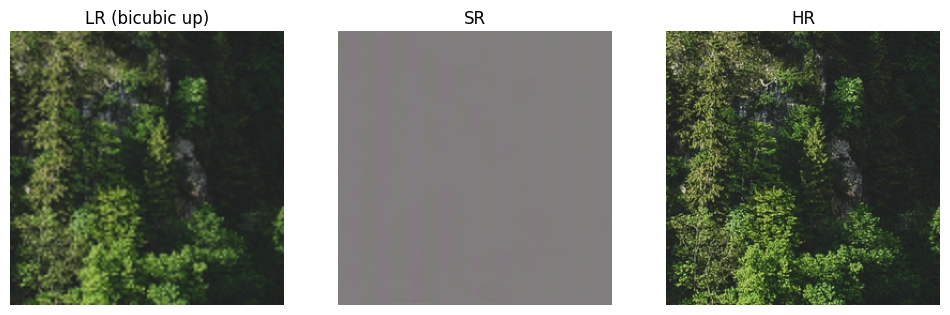

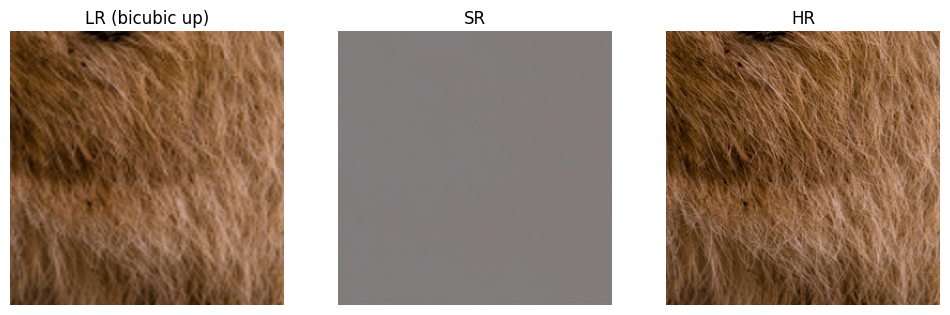

In [ ]:
for lr_small, hr in ds.take(1):
    sr = model.predict(lr_small)
    for i in range(len(sr)):
        lr_bic = tf.image.resize(lr_small[i], tf.shape(hr[i])[:2], method='bicubic')
        show_pair(lr_bic.numpy(), sr[i], hr[i].numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


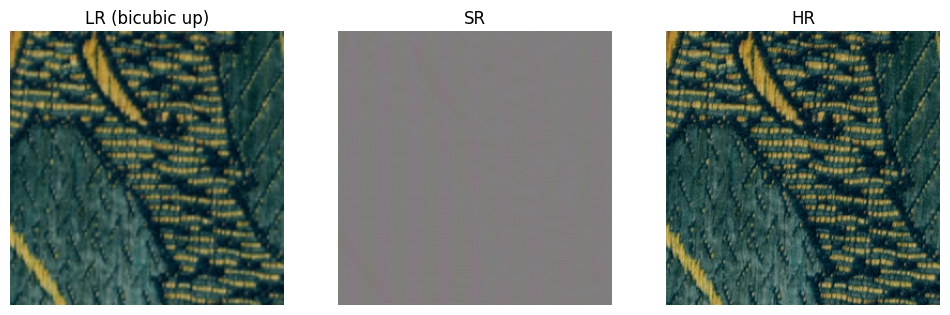

In [ ]:
for lr_small, hr in ds.take(1):
    sr = model.predict(lr_small)
    for i in range(len(sr)):
        lr_bic = tf.image.resize(lr_small[i], tf.shape(hr[i])[:2], method='bicubic')
        show_pair(lr_bic.numpy(), sr[i], hr[i].numpy())

### Architektúra modelu `build_simple_espcn`

Model je definovaný funkciou `build_simple_espcn(scale=2, channels=3)` a skladá sa z nasledujúcich vrstiev:

1.  **`layers.Input`**: Vstupná vrstva, ktorá prijíma obrázky s nízkym rozlíšením. Jej tvar (`shape`) je nastavený na `(None, None, channels)`, čo znamená, že môže prijímať obrázky akejkoľvek výšky a šírky, ale s fixným počtom kanálov (typicky 3 pre RGB).

2.  **`layers.Conv2D(32, 3, activation='relu', padding='same')`**: Prvá konvolučná vrstva:
    *   **`32`**: Počet filtrov (feature maps).
    *   **`3`**: Veľkosť jadra filtra (3x3).
    *   **`activation='relu'`**: Používa aktivačnú funkciu ReLU, ktorá pomáha modelu učiť sa nelineárne vlastnosti.
    *   **`padding='same'`**: Zabezpečuje, že výška a šírka výstupu z tejto vrstvy sú rovnaké ako vstup (za predpokladu stride=1).

3.  **`layers.Conv2D(16, 3, activation='relu', padding='same')`**: Druhá konvolučná vrstva s menším počtom filtrov (16), ale rovnakou veľkosťou jadra a aktivačnou funkciou. Táto vrstva ďalej spracováva črty získané z predchádzajúcej vrstvy.

4.  **`layers.Conv2D((scale**2)*channels, 3, padding='same')`**: Tretia konvolučná vrstva. Toto je kľúčová vrstva pre sub-pixelovú konvolúciu:
    *   **`(scale**2)*channels`**: Počet filtrov je nastavený na `(mierka^2) * počet_kanálov`. Napríklad, ak `scale=2` a `channels=3`, bude to `(2^2)*3 = 12` filtrov. Tieto filtre generujú výstup, ktorý bude neskôr reorganizovaný na obrázok s vyšším rozlíšením.
    *   **`3`**: Veľkosť jadra filtra (3x3).
    *   **`padding='same'`**: Udržiava rozmery výstupu rovnaké ako vstupu.

5.  **`pixel_shuffle(scale)`**: Táto vrstva je implementovaná pomocou `layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale))`. Je to jadro ESPCN architektúry. Funkcia `tf.nn.depth_to_space` presúva pixely z priestorovej dimenzie na hĺbkovú dimenziu (kanály) a naopak, čo efektívne zvyšuje rozlíšenie obrázka. Ak bol vstup do tejto vrstvy napríklad obrázok 64x64 s 12 kanálmi (pre `scale=2`, `channels=3`), výstupom bude obrázok 128x128 s 3 kanálmi, čím sa efektívne zvýši rozlíšenie bez tradičnej upsampling operácie (ako je bilineárna alebo bikubická interpolácia), ktorá by len zväčšila pixely.

6.  **`layers.Activation('sigmoid')`**: Posledná aktivačná vrstva Sigmoid. Táto funkcia škáluje hodnoty pixelov výstupného obrázka do rozsahu [0, 1], čo je typické pre obrázky, ktoré sa následne spracovávajú ako float32 a reprezentujú intenzitu pixelov.

**Zhrnutie toku dát:**

Model prijíma obrázok s nízkym rozlíšením (LR), extrahuje z neho črty pomocou prvých dvoch konvolučných vrstiev. Tretia konvolučná vrstva generuje "predpovede" pixelov pre vyššie rozlíšenie, ktoré sú "zbalené" do hĺbkovej dimenzie. Následne vrstva `pixel_shuffle` "rozbalí" tieto pixely a usporiada ich do požadovaného vysokého rozlíšenia. Nakoniec, Sigmoid zabezpečí, že výstup je v platnom rozsahu pre obrázky.

In [ ]:
psnr_values = []
num_samples = 0

for lr_small, hr in ds:
    sr = model.predict(lr_small, verbose=0)
    # Ensure both hr and sr are float32 in range [0, 1]
    # hr is already in [0, 1] due to prepare_example
    # sr is in [0, 1] due to sigmoid activation

    for i in range(len(sr)):
        current_psnr = compute_psnr(hr[i], sr[i])
        psnr_values.append(current_psnr.numpy())
    num_samples += len(sr)

if psnr_values:
    average_psnr = np.mean(psnr_values)
    print(f"Priemerná PSNR na {num_samples} vzorkách: {average_psnr:.2f}")
else:
    print("Žiadne vzorky na vyhodnotenie PSNR.")

Priemerná PSNR na 800 vzorkách: 28.94


In [ ]:
ssim_values = []
num_samples_ssim = 0

for lr_small, hr in ds:
    sr = model.predict(lr_small, verbose=0)
    # Ensure both hr and sr are float32 in range [0, 1]
    # hr is already in [0, 1] due to prepare_example
    # sr is in [0, 1] due to sigmoid activation

    for i in range(len(sr)):
        current_ssim = tf.image.ssim(hr[i], sr[i], max_val=1.0)
        ssim_values.append(current_ssim.numpy())
    num_samples_ssim += len(sr)

if ssim_values:
    average_ssim = np.mean(ssim_values)
    print(f"Priemerná SSIM na {num_samples_ssim} vzorkách: {average_ssim:.4f}")
else:
    print("Žiadne vzorky na vyhodnotenie SSIM.")

Priemerná SSIM na 800 vzorkách: 0.8797


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.show()

In [ ]:
model.save('simple_espcn_model.keras')

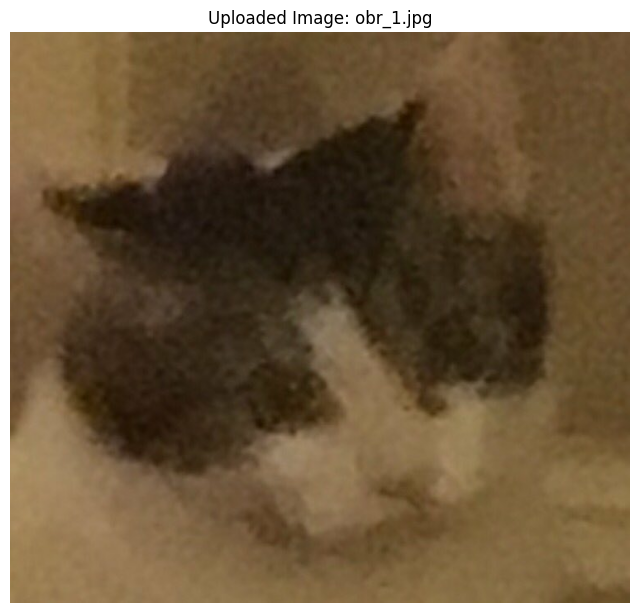

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Get the filename from the uploaded dictionary
first_uploaded_file = next(iter(uploaded.keys()))
filepath = f'/content/{first_uploaded_file}'

# Read and decode the image
img = tf.io.read_file(filepath)
img = tf.image.decode_image(img, channels=3)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(f'Uploaded Image: {first_uploaded_file}')
plt.axis('off')
plt.show()

Model bol úspešne uložený do súboru `simple_espcn_model.keras`.

In [ ]:
from google.colab import files

print("Nahrajte svoje obrázky (napríklad .jpg, .png).")
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Nahrajte svoje obrázky (napríklad .jpg, .png).


Saving obr_1.jpg to obr_1.jpg
User uploaded file "obr_1.jpg" with length 34077 bytes


Po nahraní obrázkov by ste museli upraviť časť kódu, ktorá načítava dataset `div2k`. Namiesto `tfds.load('div2k')` by ste museli načítať svoje obrázky. Napríklad, ak máte obrázky v priečinku `/content/my_images/` a chcete načítať jeden konkrétny obrázok:

```python
# Príklad načítania jedného vlastného obrázka
# filepath = '/content/my_image.png' # Upravte cestu k vášmu obrázku
# custom_image_hr = tf.io.read_file(filepath)
# custom_image_hr = tf.image.decode_image(custom_image_hr, channels=3)

# Ak by ste chceli spracovať viacero obrázkov a vytvoriť z nich dataset,
# museli by ste zozbierať cesty k súborom a potom ich mapovať cez funkciu.
# Napríklad, ak nahraté obrázky majú rovnakú veľkosť a môžete ich priamo použiť:

# Zatiaľ pre ukážku vezmeme jeden z nahraných obrázkov
# Prispôsobte si to podľa toho, koľko a aké obrázky chcete testovať
first_uploaded_file = next(iter(uploaded.keys()))
filepath = f'/content/{first_uploaded_file}'

hr_img = tf.io.read_file(filepath)
hr_img = tf.image.decode_image(hr_img, channels=3)
hr_img = tf.image.convert_image_dtype(hr_img, tf.float32)

# Pripravíme obrázok pre model (downscale, crop ak je príliš veľký atď.)
# Pre jeden obrázok nemusíme použiť random_crop, ale môžeme ho len zmenšiť
# Model očakáva dávku obrázkov, takže musíme pridať dimenziu dávky

# Uistite sa, že obrázok má rovnakú škálu, akú očakáva model
# Ak je obrázok už HR, tak ho len zmenšíme na LR

# Ak je váš obrázok príliš veľký pre CROP_SIZE, môžete ho najprv zmenšiť:
# hr_img = tf.image.resize(hr_img, [CROP_SIZE * SCALE, CROP_SIZE * SCALE])

lr_custom = downscale(hr_img, SCALE)
lr_custom = tf.expand_dims(lr_custom, axis=0) # Pridajte dávkovú dimenziu

# Vykonajte super-rozlíšenie pomocou vášho trénovaného modelu
sr_custom = model.predict(lr_custom)

# Pre vizualizáciu:
lr_bicubic_custom = tf.image.resize(lr_custom[0], tf.shape(hr_img)[:2], method='bicubic')
show_pair(lr_bicubic_custom.numpy(), sr_custom[0], hr_img.numpy())

# Môžete tiež vypočítať PSNR pre váš vlastný obrázok
psnr_value = compute_psnr(hr_img, sr_custom[0])
print(f"PSNR pre vlastný obrázok: {psnr_value.numpy():.2f}")
```

**Dôležité body, na ktoré treba pamätať:**

*   **Formát obrázka**: Uistite sa, že vaše nahrané obrázky sú v podporovanom formáte (napr. JPG, PNG).
*   **Rozmery**: `tf.image.random_crop` vo funkcii `prepare_example` očakáva, že vstupný obrázok je dostatočne veľký na vykonanie orezania. Ak sú vaše obrázky menšie, mali by ste túto časť kódu prispôsobiť.
*   **`CROP_SIZE` a `SCALE`**: Ak boli vaše vlastné obrázky pripravené inak ako s pôvodnými `CROP_SIZE` a `SCALE` hodnotami, môžete ich potrebovať upraviť alebo model pretrénovať.
*   **Dávkovanie**: Váš model očakáva vstup vo forme dávky (batch). Pre jeden obrázok pridajte dimenziu dávky pomocou `tf.expand_dims(image, axis=0)`.

Ak máte konkrétne obrázky alebo štruktúru súborov, môžem vám pomôcť s presnejšou úpravou kódu na načítanie a spracovanie vašich dát.